In [2]:
import pandas as pd
import numpy as np
# Demographics like age, gender, and account details of our clients.
final_demo = pd.read_csv ('https://raw.githubusercontent.com/data-bootcamp-v4/lessons/refs/heads/main/5_6_eda_inf_stats_tableau/project/files_for_project/df_final_demo.txt')
# A list revealing which clients were part of the grand experiment
df_final_experiment_clients = pd.read_csv ('https://raw.githubusercontent.com/data-bootcamp-v4/lessons/refs/heads/main/5_6_eda_inf_stats_tableau/project/files_for_project/df_final_experiment_clients.txt')
# A detailed trace of client interactions online, divided into two parts: 
# pt_1 and pt_2. It's recommended to merge these two files prior to a comprehensive data analysis.
df_final_web_data_pt_1 = pd.read_csv ('https://raw.githubusercontent.com/data-bootcamp-v4/lessons/refs/heads/main/5_6_eda_inf_stats_tableau/project/files_for_project/df_final_web_data_pt_1.txt')
df_final_web_data_pt_2 = pd.read_csv ('https://raw.githubusercontent.com/data-bootcamp-v4/lessons/refs/heads/main/5_6_eda_inf_stats_tableau/project/files_for_project/df_final_web_data_pt_2.txt')
# pt1 and pt2 are combined
combined = pd.concat([df_final_web_data_pt_1,df_final_web_data_pt_1], ignore_index=True)


In [3]:
# drop dublicates
datasets = [final_demo, df_final_experiment_clients, combined]
datasets = [df.drop_duplicates() for df in datasets]

In [23]:
# #inconistent:  0   client_id  70609 non-null  int64 
#                  1   Variation  50500 non-null  object - NaN values. Clearify what with it
df_final_experiment_clients.head()

combined


,client_id,visitor_id,visit_id,process_step,date_time
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04
...,...,...,...,...,...
686277,2443347,465784886_73090545671,136329900_10529659391_316129,confirm,2017-03-31 15:15:46
686278,2443347,465784886_73090545671,136329900_10529659391_316129,step_3,2017-03-31 15:14:53
686279,2443347,465784886_73090545671,136329900_10529659391_316129,step_2,2017-03-31 15:12:08
686280,2443347,465784886_73090545671,136329900_10529659391_316129,step_1,2017-03-31 15:11:37


In [5]:

final_demo.head()
# Who are the primary clients using this online process? - Test group
final_demo_clean = final_demo.copy()
final_demo_clean['gender'] = final_demo_clean['gendr'].replace(['U', 'X', 'NaN'], 'U')

# final_demo[['client_id', 'clnt_age', 'gendr']] 

median_age = final_demo_clean['clnt_age'].median()
median_tenure_year = final_demo_clean['clnt_tenure_yr'].median()
median_tenure_month = final_demo_clean['clnt_tenure_mnth'].median()
final_demo_clean['tenure_years'] = final_demo_clean['clnt_tenure_yr'].apply(lambda x: 'new-standing' if x<median_tenure_year else 'long-standing')
final_demo_clean['tenure_month'] = final_demo_clean['clnt_tenure_mnth'].apply(lambda x: 'new-standing' if x<median_tenure_month else 'long-standing')
final_demo_clean['age_group'] = final_demo_clean['clnt_age'].apply(lambda x: 'younger' if x<median_age else 'older')

clients_age_tenure = final_demo_clean[['client_id', 'gender', 'age_group', 'tenure_years', 'tenure_month']]
test_group = df_final_experiment_clients[df_final_experiment_clients['Variation'] == 'Test']
merged_clients = pd.merge(clients_age_tenure, test_group, on='client_id', how='inner')
merged_clients.head()



,client_id,gender,age_group,tenure_years,tenure_month,Variation
0,836976,U,older,new-standing,new-standing,Test
1,1439522,U,younger,new-standing,new-standing,Test
2,1562045,M,older,long-standing,long-standing,Test
3,388801,M,older,long-standing,long-standing,Test
4,8198645,F,older,long-standing,long-standing,Test


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- load (skip if already in memory) ---
try:
    final_demo
    exp
    web1
    web2
except NameError:
    final_demo = pd.read_csv('https://raw.githubusercontent.com/data-bootcamp-v4/lessons/refs/heads/main/5_6_eda_inf_stats_tableau/project/files_for_project/df_final_demo.txt')
    exp = pd.read_csv('https://raw.githubusercontent.com/data-bootcamp-v4/lessons/refs/heads/main/5_6_eda_inf_stats_tableau/project/files_for_project/df_final_experiment_clients.txt')
    web1 = pd.read_csv('https://raw.githubusercontent.com/data-bootcamp-v4/lessons/refs/heads/main/5_6_eda_inf_stats_tableau/project/files_for_project/df_final_web_data_pt_1.txt')
    web2 = pd.read_csv('https://raw.githubusercontent.com/data-bootcamp-v4/lessons/refs/heads/main/5_6_eda_inf_stats_tableau/project/files_for_project/df_final_web_data_pt_2.txt')

# --- combine web correctly (pt1 + pt2) ---
web = pd.concat([web1, web2], ignore_index=True)
web = web[['client_id','visitor_id','visit_id','process_step','date_time']].drop_duplicates()
web['date_time'] = pd.to_datetime(web['date_time'], errors='coerce')

# process step ordering
step_order = {"initial":0, "step_1":1, "step_2":2, "step_3":3, "confirm":4}
web['step_num'] = web['process_step'].map(step_order)

# --- clean demo ---
demo = final_demo.copy()
demo['gender'] = demo['gendr'].replace({'X':'U'}).fillna('U')  # collapse to U
age_med   = demo['clnt_age'].median()
tenure_y_med = demo['clnt_tenure_yr'].median()

demo['age_group']   = np.where(demo['clnt_age'] < age_med, 'younger', 'older')
demo['tenure_group'] = np.where(demo['clnt_tenure_yr'] < tenure_y_med, 'new-standing', 'long-standing')
demo = demo[['client_id','gender','clnt_age','clnt_tenure_yr','bal','num_accts',
             'calls_6_mnth','logons_6_mnth','age_group','tenure_group']].drop_duplicates()

# --- attach experiment variation ---
if 'Variation' in exp.columns and 'variation' not in exp.columns:
    exp = exp.rename(columns={'Variation':'variation'})
exp = exp[['client_id','variation']].drop_duplicates()

# active users (any web activity)
active = (web[['client_id']].drop_duplicates()
          .merge(demo, on='client_id', how='left')
          .merge(exp, on='client_id', how='left'))


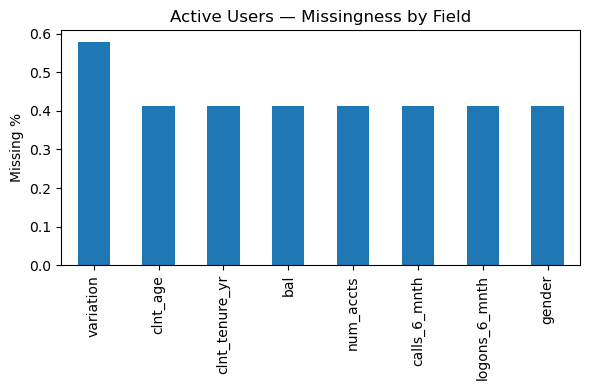

In [7]:
core_cols = ['gender','clnt_age','clnt_tenure_yr','bal','num_accts',
             'calls_6_mnth','logons_6_mnth','variation']
miss = active[core_cols].isnull().mean().sort_values(ascending=False)

plt.figure(figsize=(6,4))
miss.plot(kind='bar')
plt.ylabel('Missing %')
plt.title('Active Users — Missingness by Field')
plt.tight_layout(); plt.show()


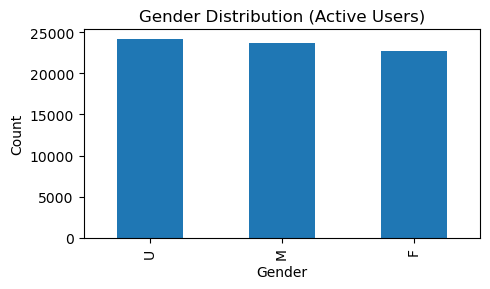

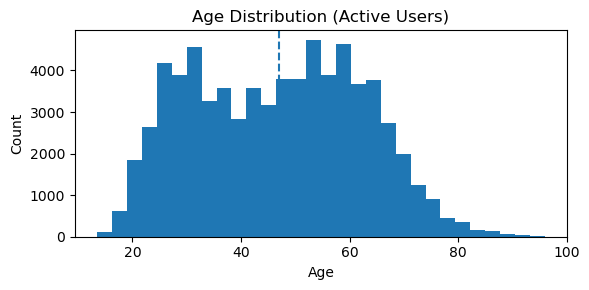

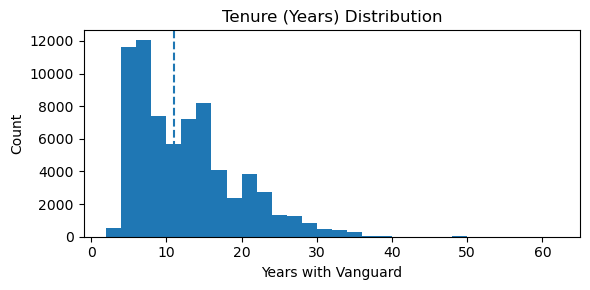

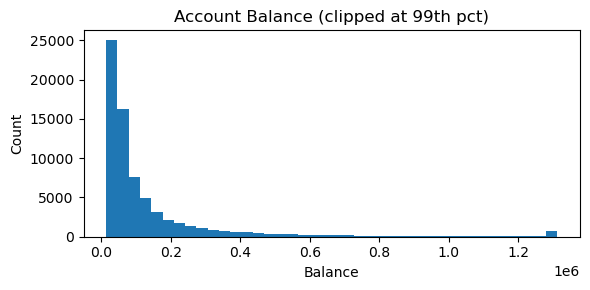

In [8]:
# Gender
g = active['gender'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(5,3))
g.plot(kind='bar')
plt.title('Gender Distribution (Active Users)')
plt.ylabel('Count'); plt.xlabel('Gender')
plt.tight_layout(); plt.show()

# Age
plt.figure(figsize=(6,3))
active['clnt_age'].dropna().plot(kind='hist', bins=30)
plt.axvline(active['clnt_age'].median(), linestyle='--')
plt.title('Age Distribution (Active Users)')
plt.xlabel('Age'); plt.ylabel('Count')
plt.tight_layout(); plt.show()

# Tenure (years)
plt.figure(figsize=(6,3))
active['clnt_tenure_yr'].dropna().plot(kind='hist', bins=30)
plt.axvline(active['clnt_tenure_yr'].median(), linestyle='--')
plt.title('Tenure (Years) Distribution')
plt.xlabel('Years with Vanguard'); plt.ylabel('Count')
plt.tight_layout(); plt.show()

# Balance (clip long tail for readability)
bal = active['bal'].clip(upper=active['bal'].quantile(0.99))
plt.figure(figsize=(6,3))
bal.dropna().plot(kind='hist', bins=40)
plt.title('Account Balance (clipped at 99th pct)')
plt.xlabel('Balance'); plt.ylabel('Count')
plt.tight_layout(); plt.show()


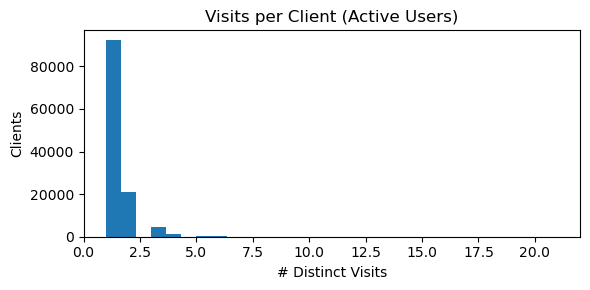

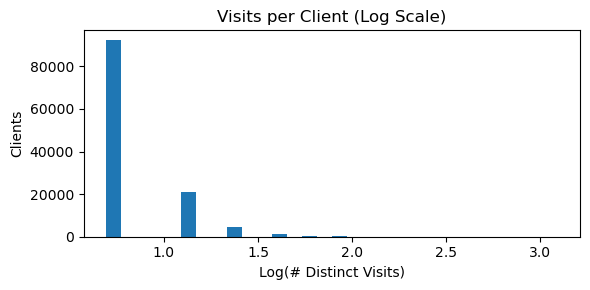

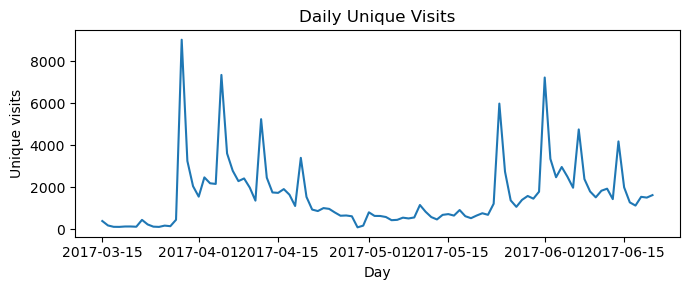

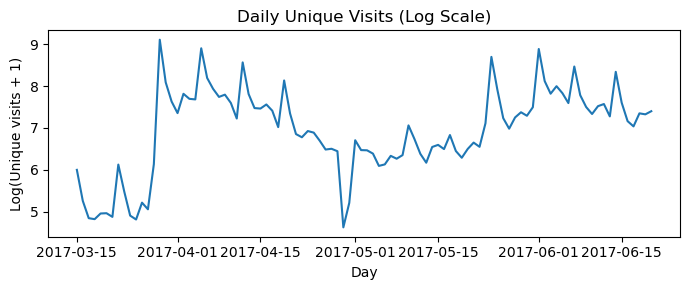

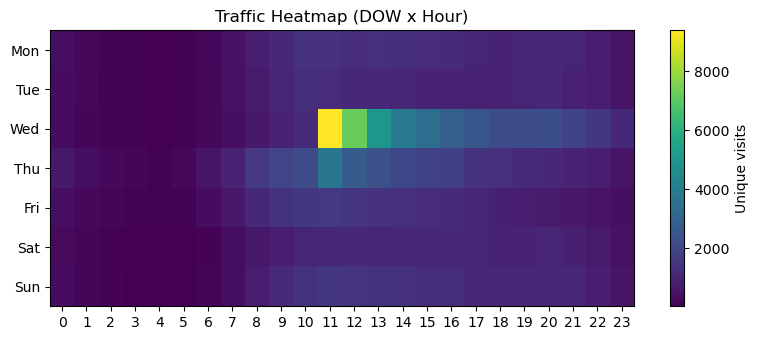

In [25]:
# Visits per client
if 'visit_id' in web.columns:
    visits_per_client = (web.groupby('client_id')['visit_id'].nunique()
                           .sort_values(ascending=False))
    plt.figure(figsize=(6,3))
    visits_per_client.plot(kind='hist', bins=30)
    plt.title('Visits per Client (Active Users)')
    plt.xlabel('# Distinct Visits'); plt.ylabel('Clients')
    plt.tight_layout(); plt.show()

# Visits per client (LOG)
if 'visit_id' in web.columns:
    visits_per_client = (web.groupby('client_id')['visit_id'].nunique()
                           .sort_values(ascending=False))

    # Apply log transform (add 1 so log(0) doesn’t break)
    log_visits = np.log1p(visits_per_client)

    plt.figure(figsize=(6,3))
    log_visits.plot(kind='hist', bins=30)
    plt.title('Visits per Client (Log Scale)')
    plt.xlabel('Log(# Distinct Visits)')
    plt.ylabel('Clients')
    plt.tight_layout()
    plt.show()

# Activity over time (daily visits)
daily = (web.dropna(subset=['date_time'])
           .assign(day=lambda d: d['date_time'].dt.date)
           .groupby('day')['visit_id'].nunique())
plt.figure(figsize=(7,3))
daily.plot()
plt.title('Daily Unique Visits'); plt.xlabel('Day'); plt.ylabel('Unique visits')
plt.tight_layout(); plt.show()

import numpy as np
import matplotlib.pyplot as plt

daily = (web.dropna(subset=['date_time'])
           .assign(day=lambda d: d['date_time'].dt.date)
           .groupby('day')['visit_id'].nunique())

# Apply log transform
daily_log = np.log1p(daily)

plt.figure(figsize=(7,3))
daily_log.plot()
plt.title('Daily Unique Visits (Log Scale)')
plt.xlabel('Day'); plt.ylabel('Log(Unique visits + 1)')
plt.tight_layout(); plt.show()

# Day-of-week & hour-of-day heat map
w = web.dropna(subset=['date_time']).copy()
w['dow'] = w['date_time'].dt.dayofweek  # 0=Mon
w['hr']  = w['date_time'].dt.hour
heat = w.pivot_table(index='dow', columns='hr', values='visit_id',
                     aggfunc='nunique', fill_value=0)
plt.figure(figsize=(8,3.5))
plt.imshow(heat, aspect='auto')
plt.colorbar(label='Unique visits')
plt.yticks(range(7), ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.xticks(range(24), range(24))
plt.title('Traffic Heatmap (DOW x Hour)')
plt.tight_layout(); plt.show()


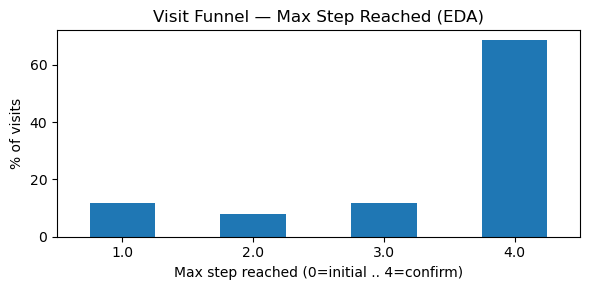

<class 'pandas.core.frame.DataFrame'>
Index: 744641 entries, 285514 to 648534
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     744641 non-null  int64         
 1   visitor_id    744641 non-null  object        
 2   visit_id      744641 non-null  object        
 3   process_step  744641 non-null  object        
 4   date_time     744641 non-null  datetime64[ns]
 5   step_num      509642 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 39.8+ MB


In [19]:
# Max step reached per visit

w_sorted = web.sort_values(['client_id','visit_id','step_num','date_time'])
vis = (w_sorted.groupby(['client_id','visit_id'], as_index=False)
               .agg(max_step=('step_num','max')))

step_counts = vis['max_step'].value_counts().sort_index()
plt.figure(figsize=(6,3))
(step_counts / step_counts.sum() * 100).plot(kind='bar')
plt.xticks(rotation=0)
plt.ylabel('% of visits'); plt.xlabel('Max step reached (0=initial .. 4=confirm)')
plt.title('Visit Funnel — Max Step Reached (EDA)')
plt.tight_layout(); plt.show()
w_sorted.info()

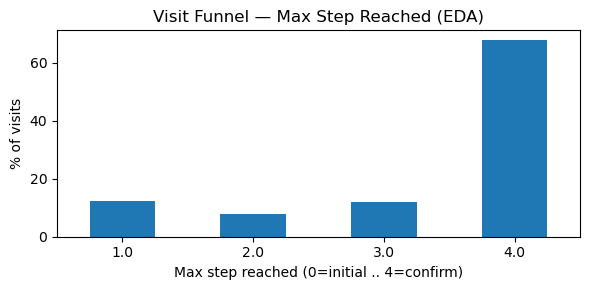

,client_id,visitor_id,visit_id,process_step,date_time,step_num,Variation
0,555,402506806_56087378777,637149525_38041617439_716659,step_1,2017-04-15 12:58:03,1.0,Test
1,555,402506806_56087378777,637149525_38041617439_716659,step_2,2017-04-15 12:58:35,2.0,Test
2,555,402506806_56087378777,637149525_38041617439_716659,step_3,2017-04-15 13:00:14,3.0,Test
3,555,402506806_56087378777,637149525_38041617439_716659,confirm,2017-04-15 13:00:34,4.0,Test
4,555,402506806_56087378777,637149525_38041617439_716659,start,2017-04-15 12:57:56,NaN,Test


In [ ]:
# Max step reached per visit of testgroup

w_sorted = web.sort_values(['client_id','visit_id','step_num','date_time'])
merged_w_test_group = pd.merge(w_sorted,test_group, on='client_id', how='inner')

vis = (merged_w_test_group.groupby(['client_id','visit_id'], as_index=False)
               .agg(max_step=('step_num','max')))

step_counts = vis['max_step'].value_counts().sort_index()
plt.figure(figsize=(6,3))
(step_counts / step_counts.sum() * 100).plot(kind='bar')
plt.xticks(rotation=0)
plt.ylabel('% of visits'); plt.xlabel('Max step reached (0=initial .. 4=confirm)')
plt.title('Visit Funnel — Max Step Reached (EDA)')
plt.tight_layout(); plt.show()

merged_w_test_group.info()

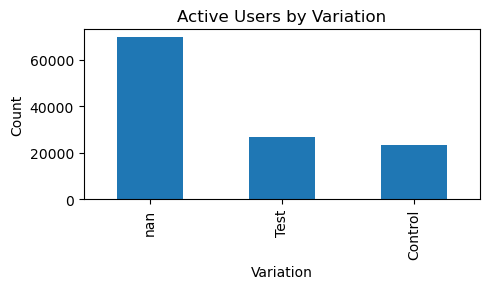

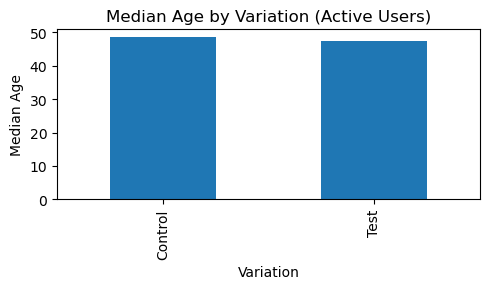

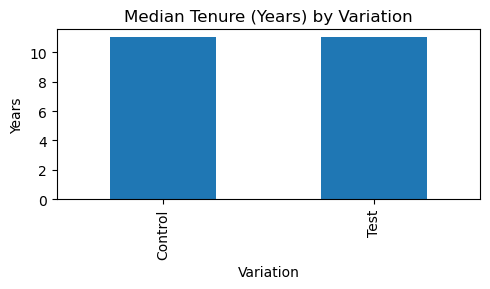

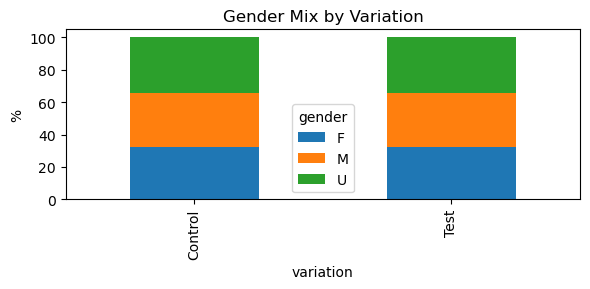

In [11]:
# Variation share among active users
var_share = active['variation'].value_counts(dropna=False)
plt.figure(figsize=(5,3))
var_share.plot(kind='bar')
plt.title('Active Users by Variation')
plt.ylabel('Count'); plt.xlabel('Variation')
plt.tight_layout(); plt.show()

# Age by variation (median bars)
summary_age = (active.groupby('variation')['clnt_age']
                     .median()
                     .sort_values(ascending=False))
plt.figure(figsize=(5,3))
summary_age.plot(kind='bar')
plt.title('Median Age by Variation (Active Users)')
plt.ylabel('Median Age'); plt.xlabel('Variation')
plt.tight_layout(); plt.show()

# Tenure by variation (median)
summary_tenure = active.groupby('variation')['clnt_tenure_yr'].median()
plt.figure(figsize=(5,3))
summary_tenure.plot(kind='bar')
plt.title('Median Tenure (Years) by Variation')
plt.ylabel('Years'); plt.xlabel('Variation')
plt.tight_layout(); plt.show()

# Gender composition by variation (stacked %)
gender_var = (active.pivot_table(index='variation', columns='gender',
                                 values='client_id', aggfunc='nunique', fill_value=0))
gender_pct = gender_var.div(gender_var.sum(axis=1), axis=0) * 100
ax = gender_pct.plot(kind='bar', stacked=True, figsize=(6,3))
ax.set_ylabel('%'); ax.set_title('Gender Mix by Variation')
plt.tight_layout(); plt.show()


In [12]:
import pandas as pd
import numpy as np
# --- ensure step order is available ---
step_order = {"initial":0, "step_1":1, "step_2":2, "step_3":3, "confirm":4}
if "step_num" not in web.columns:
    web = web.copy()
    web["step_num"] = web["process_step"].map(step_order)
web["date_time"] = pd.to_datetime(web["date_time"], errors="coerce")
# --- 1) Visit-level funnel (one row per visit) ---
w_sorted = web.sort_values(["client_id","visit_id","step_num","date_time"])
g = w_sorted.groupby(["client_id","visit_id"], as_index=False)
visit = g.agg(
    completed=("process_step", lambda s: int((s=="confirm").any())),
    max_step_reached=("step_num","max"),
    t_initial=("date_time","min"),
    t_confirm=("date_time",
               lambda s: s[w_sorted.loc[s.index,"process_step"]=="confirm"].min()
                         if (w_sorted.loc[s.index,"process_step"]=="confirm").any() else pd.NaT)
)
visit["secs_to_complete"] = (visit["t_confirm"] - visit["t_initial"]).dt.total_seconds()
# attach variation (and demographics if you want segments later)
funnel = (visit.merge(exp.rename(columns={"Variation":"variation"}), on="client_id", how="left")
               .merge(demo[["client_id","clnt_age","clnt_tenure_yr","gender"]], on="client_id", how="left"))
# --- 2) KPI #1: Completion Rate by variation ---
kpi_cr = (funnel.groupby("variation")["completed"]
                .agg(visits="count", completes="sum"))
kpi_cr["cr_pct"] = 100 * kpi_cr["completes"] / kpi_cr["visits"]
kpi_cr = kpi_cr.reset_index()
display(kpi_cr)
# --- Optional: step drop-off by variation (percentage) ---
reached = (funnel.groupby("variation")["max_step_reached"]
                 .value_counts()
                 .unstack(fill_value=0))
for s in range(0,5):  # ensure all columns exist
    if s not in reached.columns: reached[s]=0
reached = reached[sorted(reached.columns)]
reached_pct = reached.div(reached.sum(axis=1), axis=0) * 100
reached_pct.columns = [f"s{s}" for s in reached_pct.columns]
display(reached_pct)
# --- 3) KPI #2: Time to complete (completed only) ---
kpi_speed = (funnel[funnel["completed"]==1]
             .groupby("variation")["secs_to_complete"]
             .agg(completed_visits="count",
                  avg_secs="mean",
                  p50_secs=lambda s: s.quantile(0.5),
                  p90_secs=lambda s: s.quantile(0.9))
             .round(1)
             .reset_index())
display(kpi_speed)
# --- per-step duration (first time at step k to first time at k+1) ---
first_step_time = (w_sorted.groupby(["client_id","visit_id","step_num"], as_index=False)
                            .agg(step_time=("date_time","min")))
first_step_time["next_time"] = (first_step_time
    .sort_values(["client_id","visit_id","step_num"])
    .groupby(["client_id","visit_id"])["step_time"].shift(-1))
first_step_time["secs_in_step"] = (first_step_time["next_time"] - first_step_time["step_time"]).dt.total_seconds()
# add variation on visit to compute per-step by arm
visit_var = funnel[["client_id","visit_id","variation"]]
per_step = (first_step_time.merge(visit_var, on=["client_id","visit_id"], how="left")
                          .dropna(subset=["secs_in_step"]))
kpi_time_per_step = (per_step.groupby(["variation","step_num"])["secs_in_step"]
                              .median()
                              .unstack("variation")
                              .rename(index={0:"initial",1:"step_1",2:"step_2",3:"step_3",4:"confirm"})
                              .round(1))
display(kpi_time_per_step)
# --- 4) KPI #3: Error rate (any backward transition in a visit) ---
tmp = w_sorted.copy()
tmp["next_step_num"] = tmp.groupby(["client_id","visit_id"])["step_num"].shift(-1)
tmp["went_back"] = (tmp["next_step_num"] < tmp["step_num"]).astype(float)
visit_error = (tmp.groupby(["client_id","visit_id"], as_index=False)
                 .agg(any_back=("went_back", "max")))
visit_error = visit_error.merge(visit_var, on=["client_id","visit_id"], how="left")
kpi_error = (visit_error.groupby("variation")["any_back"]
                        .mean()
                        .mul(100)
                        .round(2)
                        .rename("error_rate_pct")
                        .reset_index())
display(kpi_error)
# --- 5) Redesign outcome table (side-by-side) ---
outcome = (kpi_cr.merge(kpi_speed, on="variation", how="left")
                 .merge(kpi_error, on="variation", how="left"))
display(outcome)
# --- 6) Export small tables for Tableau/slides (optional) ---
kpi_cr.to_csv("kpi_completion_rate.csv", index=False)
kpi_speed.to_csv("kpi_time_to_complete.csv", index=False)
kpi_error.to_csv("kpi_error_rate.csv", index=False)
reached_pct.reset_index().to_csv("kpi_step_dropoff_pct.csv", index=False)
kpi_time_per_step.reset_index().to_csv("kpi_time_per_step_median.csv", index=False)
print("Saved KPI CSVs.")

,variation,visits,completes,cr_pct
0,Control,32243,16088,49.896101
1,Test,37204,21791,58.571659


,s0.0,s1.0,s2.0,s3.0,s4.0
variation,,,,,
Control,0.0,14.162377,8.268818,12.358640,65.210166
Test,0.0,12.166117,8.010087,11.985555,67.838242


,variation,completed_visits,avg_secs,p50_secs,p90_secs
0,Control,16088,369.1,258.0,753.0
1,Test,21791,313.2,196.0,679.0


variation,Control,Test
step_num,,
step_1,22.0,31.0
step_2,79.0,73.0
step_3,89.0,57.0


,variation,error_rate_pct
0,Control,0.0
1,Test,0.0


,variation,visits,completes,cr_pct,completed_visits,avg_secs,p50_secs,p90_secs,error_rate_pct
0,Control,32243,16088,49.896101,16088,369.1,258.0,753.0,0.0
1,Test,37204,21791,58.571659,21791,313.2,196.0,679.0,0.0


Saved KPI CSVs.
